# 0.0 Imports

In [99]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, MiniBatchKMeans
from pycaret.utils import enable_colab
from pycaret.classification import *
%matplotlib inline

# 1.0 Data read

In [2]:
azdias = pd.read_csv('data/clean_AZDIAS.csv').drop('Unnamed: 0', axis=1)
customers = pd.read_csv('data/clean_CUSTOMERS.csv').drop('Unnamed: 0', axis=1)

In [3]:
#Let's drop the LNR column as it works as an index
azdias.drop(columns=['LNR'], axis=1, inplace=True)
customers.drop(columns=['LNR', 'ONLINE_PURCHASE'], axis=1, inplace=True)

In [4]:
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,4.0,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1
1,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,2.0,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3
2,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,0.0,7.0,10.0,11.0,-1.0,9.0,7.0,3,2,4
3,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,2.0,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3
4,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,2.0,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1


In [48]:
df_train = pd.read_csv('data/clean_TRAIN.csv', low_memory=False).drop('Unnamed: 0', axis=1)
df_test = pd.read_csv('data/clean_TEST.csv', low_memory=False).drop('Unnamed: 0', axis=1)

In [47]:
df_train.head()

,LNR,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,RESPONSE,ANREDE_KZ,ALTERSKATEGORIE_GROB
0,1763,2,1.0,8.0,8.0,15.0,0.0,0.0,1.0,13.0,...,5.0,2.0,1.0,6.0,9.0,3.0,3,0,2,4
1,1771,1,4.0,13.0,13.0,1.0,0.0,0.0,2.0,1.0,...,1.0,2.0,1.0,4.0,9.0,7.0,1,0,2,3
2,1460,2,1.0,6.0,6.0,4.0,0.0,0.0,2.0,4.0,...,8.0,11.0,11.0,6.0,9.0,1.0,3,0,2,4
3,1783,2,1.0,9.0,9.0,53.0,0.0,0.0,1.0,44.0,...,2.0,2.0,1.0,6.0,9.0,3.0,3,0,1,3
4,1789,3,1.0,12.0,12.0,17.0,0.0,0.0,1.0,11.0,...,2.0,1.0,1.0,6.0,9.0,2.0,3,0,2,3


# 2.0 Scaling and PCA

In [5]:
def get_high_corr_cols(df, t):
    """
    Method to get the columns with chigh correlation coeficient (above the threshold).
    
    Args:
        df: dataframe to be fixed
        t: threshold for correlation coeficient

    Returns:
        df: fixed dataframe
    """

    # select the upper triangle from the correlation matrix
    upper = df.corr(method='spearman').abs().where(np.triu(np.ones(azdias.corr(method='spearman').abs().shape), k=1).astype(bool))

    # find columns with correlation coeficient higher than threshold
    pos_high_corr_cols = [column for column in upper.columns if any(upper[column] > t)]
    neg_high_corr_cols = [column for column in upper.columns if any(upper[column] < -t)]
    
    high_corr_cols = pos_high_corr_cols + neg_high_corr_cols
    
    return high_corr_cols


In [6]:
#Standardize features
scaler = StandardScaler()

#Fit then transform data
azdias_scaled = scaler.fit_transform(azdias)
customers_scaled = scaler.transform(customers)

In [7]:
# check the number of components to adopt
variance_dict = {}

for i in range(2, azdias.shape[1]-1, 2):
    pca = PCA(n_components = i, svd_solver = 'arpack')
    pca.fit(azdias_scaled)
    variance_dict[i] = pca.explained_variance_ratio_.sum().round(4)


In [8]:
variance_dict

{2: 0.1643,
 4: 0.2601,
 6: 0.3205,
 8: 0.3572,
 10: 0.3864,
 12: 0.411,
 14: 0.4318,
 16: 0.4509,
 18: 0.4682,
 20: 0.4848,
 22: 0.4999,
 24: 0.5143,
 26: 0.5274,
 28: 0.5395,
 30: 0.551,
 32: 0.5618,
 34: 0.5723,
 36: 0.5821,
 38: 0.5916,
 40: 0.6008,
 42: 0.6097,
 44: 0.618,
 46: 0.626,
 48: 0.6338,
 50: 0.6413,
 52: 0.6485,
 54: 0.6556,
 56: 0.6625,
 58: 0.6691,
 60: 0.6754,
 62: 0.6815,
 64: 0.6875,
 66: 0.6934,
 68: 0.6991,
 70: 0.7047,
 72: 0.7102,
 74: 0.7156,
 76: 0.7209,
 78: 0.7261,
 80: 0.7312,
 82: 0.7363,
 84: 0.7413,
 86: 0.7463,
 88: 0.7512,
 90: 0.756,
 92: 0.7607,
 94: 0.7654,
 96: 0.7701,
 98: 0.7746,
 100: 0.7792,
 102: 0.7836,
 104: 0.7879,
 106: 0.7923,
 108: 0.7965,
 110: 0.8007,
 112: 0.8049,
 114: 0.8089,
 116: 0.813,
 118: 0.8169,
 120: 0.8209,
 122: 0.8247,
 124: 0.8286,
 126: 0.8324,
 128: 0.8362,
 130: 0.8399,
 132: 0.8436,
 134: 0.8473,
 136: 0.8508,
 138: 0.8544,
 140: 0.8579,
 142: 0.8613,
 144: 0.8646,
 146: 0.868,
 148: 0.8712,
 150: 0.8744,
 152: 0.87

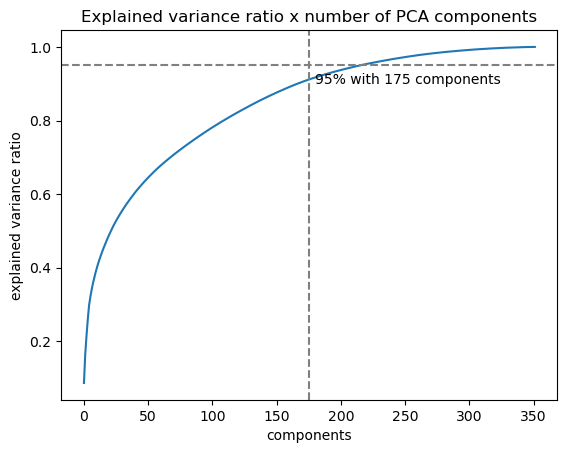

In [9]:
# plot the explained variance ratio
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('components')
plt.ylabel('explained variance ratio')
plt.title('Explained variance ratio x number of PCA components')
plt.axhline(y=0.95, color = 'gray', linestyle='--')
plt.axvline(x=175, color = 'gray', linestyle='--')
plt.annotate('95% with 175 components', (180,0.9))
plt.show()


In [15]:
n_pca = 175

In [16]:
pca = PCA(n_components = n_pca, random_state=42)

azdias_pca = pca.fit_transform(azdias_scaled)
azdias_pca = pd.DataFrame(azdias_pca)

customer_pca = pca.transform(customers_scaled)
customer_pca = pd.DataFrame(customer_pca)

In [17]:
# Convert dataframe to matrix
azdias_pcaMatrix = azdias_pca.loc[:, azdias_pca.columns].to_numpy()
azdias_pcaMatrix

array([[ 3.0319117 , -3.87730559,  1.96697124, ..., -1.15568535,
        -0.69344821,  0.1649242 ],
       [-0.10208232, -0.08991488, -1.97820125, ...,  0.62563782,
         0.57871977, -1.03006166],
       [-1.99689229,  3.58104762, -6.43572671, ..., -0.36003648,
         0.18881272, -0.67848394],
       ...,
       [-3.30317319,  1.76127685,  2.56325678, ..., -0.19063859,
         0.46940791,  0.43318778],
       [ 3.94142609, -6.46954121,  4.23321116, ..., -0.09710494,
         0.54690895,  1.10209264],
       [ 0.73671404, -0.44374917, -6.80552218, ..., -1.0685116 ,
        -0.24101572, -0.86110489]])

In [18]:
## Find optimal number of clusters via scree plot
scores = []
for i in range(1, 10):
    
    print("fitting {} clusters".format(i))
    km_i = MiniBatchKMeans(n_clusters = i, random_state = 42)
    km_i.fit(azdias_pca)
    
    score = km_i.inertia_
    scores.append(score)

fitting 1 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 2 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 3 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 4 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 5 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 6 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 7 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 8 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


fitting 9 clusters


C:\Users\iCone\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1836: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 2048 or by setting the environment variable OMP_NUM_THREADS=4
  warnings.warn(


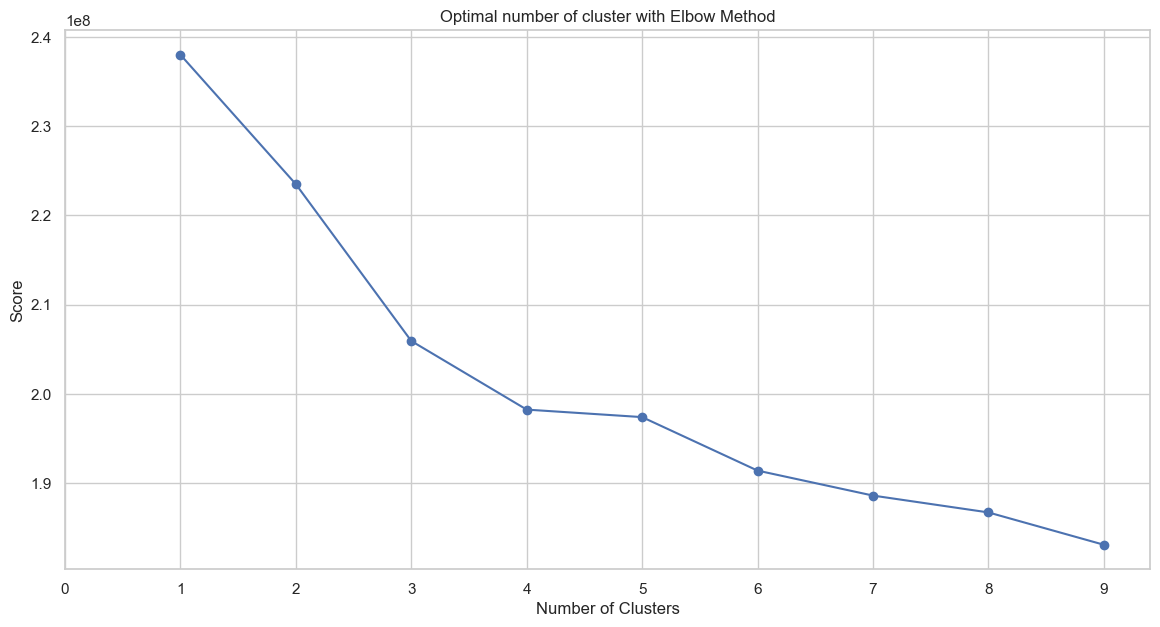

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize= (14, 7))
plt.plot(range(1, 10), scores, marker = 'o')
plt.xticks(np.arange(0, 10, 1))
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Optimal number of cluster with Elbow Method')
plt.show()


Looking at the graph and utilising the elbow approach, we will use n=4.

In [23]:
# Convert dataframes to matrix
azdiasMatrix = azdias.to_numpy()
customersMatrix = customers.to_numpy()

In [24]:
k = 4

In [25]:
kmodes = KModes(n_clusters = k, init = 'Huang', random_state = 42)

In [26]:
# train model
y_pred_azdias = kmodes.fit_predict(azdiasMatrix)

In [27]:
# create cluster column and add to the dataframe
azdias['cluster'] = kmodes.labels_
azdias.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,-1,9.0,0.0,21.0,11.0,0.0,0.0,2.0,12.0,0.0,...,8.0,11.0,10.0,3.0,9.0,4.0,5,2,1,0
1,-1,9.0,17.0,17.0,10.0,0.0,0.0,1.0,7.0,0.0,...,9.0,9.0,6.0,3.0,9.0,2.0,5,2,3,0
2,2,1.0,13.0,13.0,1.0,0.0,0.0,0.0,2.0,0.0,...,7.0,10.0,11.0,-1.0,9.0,7.0,3,2,4,2
3,-1,1.0,20.0,14.0,3.0,0.0,0.0,4.0,3.0,0.0,...,3.0,5.0,4.0,2.0,9.0,3.0,4,1,3,1
4,3,1.0,10.0,10.0,5.0,0.0,0.0,1.0,2.0,0.0,...,10.0,7.0,4.0,6.0,9.0,7.0,4,2,1,2


In [28]:
azdias.cluster.value_counts().sort_index()

0    202531
1    200439
2    195827
3    138828
Name: cluster, dtype: int64

In [29]:
# predict trained model on customers dataset
y_pred_customers = kmodes.predict(customersMatrix)

In [30]:
customers['cluster'] = y_pred_customers
customers.head()

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB,cluster
0,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,5.0,3.0,2.0,6.0,9.0,7.0,3,1,4,2
1,-1,1.0,6.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,10.0,13.0,11.0,6.0,9.0,2.0,3,2,4,2
2,-1,1.0,20.0,14.0,7.0,0.0,0.0,4.0,7.0,0.0,...,3.0,5.0,4.0,2.0,9.0,3.0,1,1,3,3
3,1,1.0,11.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,1.0,2.0,1.0,6.0,9.0,1.0,2,1,3,2
4,2,1.0,10.0,10.0,1.0,0.0,0.0,2.0,1.0,0.0,...,3.0,4.0,2.0,6.0,9.0,7.0,1,1,4,2


In [31]:
customers.cluster.value_counts().sort_index()

0     3892
1    38156
2    77261
3    10444
Name: cluster, dtype: int64

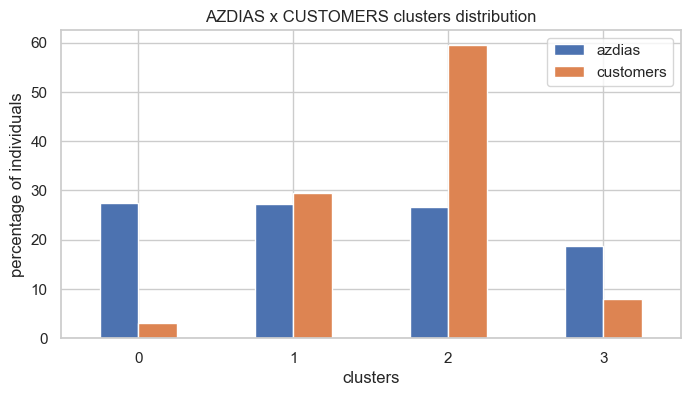

,azdias,customers
0,27.457177,2.999545
1,27.173564,29.406642
2,26.548314,59.544673
3,18.820946,8.049140


In [32]:
clusters_dict = {
    'azdias': azdias.cluster.value_counts().sort_index() / azdias.shape[0] *100,
    'customers': customers.cluster.value_counts().sort_index() / customers.shape[0] *100
}

df_clusters = pd.DataFrame(clusters_dict)

# making plot
ax = df_clusters.plot.bar(rot=0, figsize=(8,4))
ax.set_title('AZDIAS x CUSTOMERS clusters distribution')
ax.set_xlabel('clusters')
ax.set_ylabel('percentage of individuals')
plt.show()

df_clusters

In [34]:
# columns for centroids
cluster_col = ['cluster']
cols = [col for col in azdias if col not in cluster_col]

# make index for cluster interpretation
index = ['cluster_0', 'cluster_1', 'cluster_2', 'cluster_3']

# make dataframe
df_clusters_centroids = pd.DataFrame(kmodes.cluster_centroids_, columns = cols, index = index)
df_clusters_centroids

,AGER_TYP,AKT_DAT_KL,ALTER_HH,ALTERSKATEGORIE_FEIN,ANZ_HAUSHALTE_AKTIV,ANZ_HH_TITEL,ANZ_KINDER,ANZ_PERSONEN,ANZ_STATISTISCHE_HAUSHALTE,ANZ_TITEL,...,VHN,VK_DHT4A,VK_DISTANZ,VK_ZG11,W_KEIT_KIND_HH,WOHNDAUER_2008,WOHNLAGE,ZABEOTYP,ANREDE_KZ,ALTERSKATEGORIE_GROB
cluster_0,-1.0,9.0,0.0,0.0,2.0,0.0,0.0,1.0,2.0,0.0,...,2.0,9.0,8.0,10.0,6.0,9.0,3.0,4.0,2.0,1.0
cluster_1,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,3.0,3.0,5.0,4.0,9.0,7.0,4.0,1.0,3.0
cluster_2,-1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,2.0,10.0,6.0,3.0,6.0,9.0,3.0,3.0,2.0,4.0
cluster_3,-1.0,9.0,0.0,0.0,8.0,0.0,0.0,1.0,7.0,0.0,...,4.0,10.0,10.0,7.0,6.0,9.0,3.0,3.0,1.0,3.0


In [35]:
azdias_centroids = df_clusters_centroids.loc[(df_clusters_centroids.index == 'cluster_1') | (df_clusters_centroids.index == 'cluster_4')]
customers_centroids = df_clusters_centroids.loc[(df_clusters_centroids.index == 'cluster_0') | (df_clusters_centroids.index == 'cluster_2') | (df_clusters_centroids.index == 'cluster_3') ]

In [36]:
centr_dict = {'population': list(azdias_centroids.mean()),
              'customers': list(customers_centroids.mean())}

In [37]:
df_centr = pd.DataFrame(centr_dict, columns = ['population', 'customers'], index = df_clusters_centroids.columns)

In [38]:
df_centr.head()

,population,customers
AGER_TYP,-1.0,-1.000000
AKT_DAT_KL,1.0,6.333333
ALTER_HH,0.0,0.000000
ALTERSKATEGORIE_FEIN,0.0,0.000000
ANZ_HAUSHALTE_AKTIV,1.0,3.666667
